In [1]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline 
from sklearn.feature_selection import SelectKBest, f_regression 
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def load_dataset():
    csv_path= os.path.join(path,'diabetes.csv')
    return pd.read_csv(csv_path)

In [3]:
#loading dataset 
path = '.'
dataset = load_dataset()
#looking at dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
dataset.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


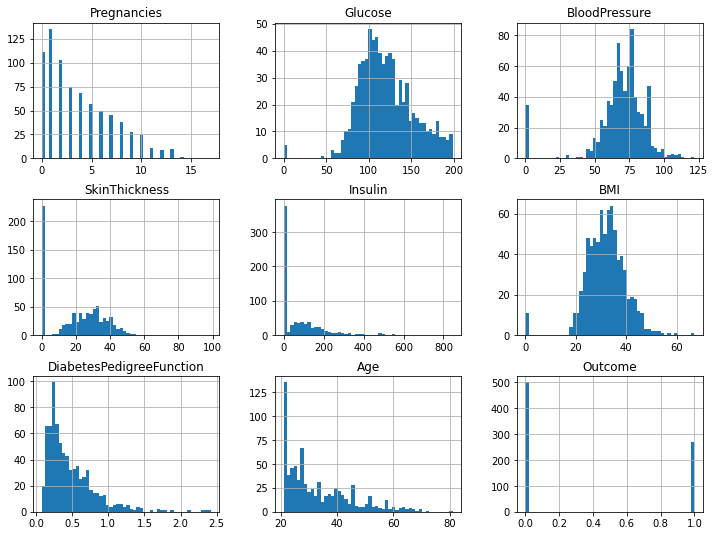

In [5]:
#Plotting data
dataset.hist(bins=50, figsize = (12,9))
plt.show()

### Preprocessing Data

In [6]:
# Looking at missing values
dataset.isna().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [7]:
## looking at missing values
# Imputation with median strategy
imputer_median = SimpleImputer(missing_values = 0, strategy = 'median')
dataset.iloc[:,1:6] = pd.DataFrame(imputer_median.fit_transform(dataset.values[:, 1:6]), # ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
                               columns=dataset.columns.values[1:6])

In [8]:
## Looking at multicollinearity
# no nominal variable

In [9]:
#Split data into training and test sets 
features = dataset.drop(['Outcome'], axis=1) 
labels = dataset['Outcome']
features_train, features_test, labels_train, labels_test=train_test_split(features, labels, test_size=0.25)
#taking a quick look at the newly created training set 
features_train.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
555,7,124.0,70.0,33.0,215.0,25.5,0.161,37
751,1,121.0,78.0,39.0,74.0,39.0,0.261,28


### Perform pipeline - kNN

#### Run pipeling

In [10]:
#Setting up a pipeline
pipe=make_pipeline(StandardScaler(),SelectKBest(f_regression) ,KNeighborsClassifier())

In [11]:
#Looking up parameters that can be passed to the pipeline 
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'selectkbest', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])

In [12]:
#putting together a parameter grid to search over using grid search
params={'selectkbest__k':[1,2,3,4,5,6], 
        'kneighborsclassifier__n_neighbors' : [3,5,7,9,11,13,15,17,19], 
        'kneighborsclassifier__weights' : ['uniform', 'distance'], 
        'kneighborsclassifier__metric' : ['euclidian', 'manhattan']}
#setting up the grid search 
gs=GridSearchCV(pipe,params,verbose=1,n_jobs=-1,cv=5)
#fitting gs to training data 
gs.fit(features_train, labels_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1049 out of 1080 | elapsed:   11.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   11.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000015BECD93DC0>)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__metric': ['euclidian',
                                                          'manhattan'],
                         'kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 11,
                                                               13, 15, 17, 19],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance'],
                         'selectkbest__k': [1, 2, 3, 4, 5, 6]},
             verbose=1)

#### perform cross-validation

In [13]:
#building a dataframe from cross-validation data 
df_cv_scores=pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')
#selecting specific columns to create a view 
df_cv_scores[['params','split0_test_score', 
              'split1_test_score', 'split2_test_score',
              'split3_test_score', 'split4_test_score',
              'mean_test_score', 'std_test_score', 'rank_test_score']].head()

,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
214,"{'kneighborsclassifier__metric': 'manhattan', ...",0.784483,0.765217,0.730435,0.791304,0.713043,0.756897,0.030455,1
197,"{'kneighborsclassifier__metric': 'manhattan', ...",0.724138,0.765217,0.739130,0.791304,0.756522,0.755262,0.022929,2
209,"{'kneighborsclassifier__metric': 'manhattan', ...",0.741379,0.747826,0.730435,0.782609,0.773913,0.755232,0.019800,3
135,"{'kneighborsclassifier__metric': 'manhattan', ...",0.758621,0.800000,0.721739,0.756522,0.739130,0.755202,0.026070,4
208,"{'kneighborsclassifier__metric': 'manhattan', ...",0.775862,0.756522,0.721739,0.782609,0.739130,0.755172,0.022618,5


In [14]:
# evaluating the model
gs.best_score_

0.756896551724138

In [15]:
#checking the selected permutation of parameters 
gs.best_params_

{'kneighborsclassifier__metric': 'manhattan',
 'kneighborsclassifier__n_neighbors': 19,
 'kneighborsclassifier__weights': 'distance',
 'selectkbest__k': 5}

#### Predict target values

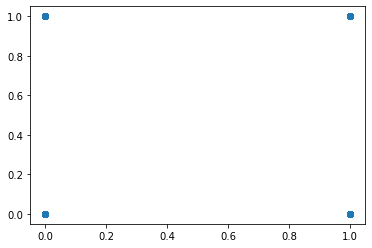

In [18]:
#checking how well the model does on the holdout-set 
gs.score(features_test,labels_test)
#plotting predicted body weights vs actual body weights of penguins 
labels_preds=gs.predict(features_test) 
plt.scatter(labels_test,labels_preds)

### Perform pipeline - Logistic

#### Run pipeling

In [19]:
#Setting up a pipeline
pipe=make_pipeline(StandardScaler(),SelectKBest(f_regression) ,LogisticRegression())

In [20]:
#Looking up parameters that can be passed to the pipeline 
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'selectkbest', 'logisticregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

In [21]:
#putting together a parameter grid to search over using grid search
params={'selectkbest__k':[1,2,3,4,5,6], 
        'logisticregression__C' : [0.001, 0.01, 0.05, 0.1, 1., 100.], 
        'logisticregression__penalty' : ['none', 'l1', 'l2', 'elasticnet'], 
        'logisticregression__solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}
#setting up the grid search 
gs=GridSearchCV(pipe,params, verbose=1, n_jobs=-1,cv=5)
#fitting gs to training data 
gs.fit(features_train, labels_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 2800 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:    5.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000015BECD93DC0>)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.05, 0.1, 1.0,
                                                   100.0],
                         'logisticregression__penalty': ['none', 'l1', 'l2',
                                                         'elasticnet'],
                         'logisticregression__solver': ['liblinear',
                                                        'newton-cg', 'lbfgs',
                                                        'sag', 'saga'],
                         'selectkbest__k': [1, 2, 3, 4, 5, 6]},
             ve

#### perform cross-validation

In [22]:
#building a dataframe from cross-validation data 
df_cv_scores=pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')
#selecting specific columns to create a view 
df_cv_scores[['params','split0_test_score', 
              'split1_test_score', 'split2_test_score',
              'split3_test_score', 'split4_test_score',
              'mean_test_score', 'std_test_score', 'rank_test_score']].head()

,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
273,"{'logisticregression__C': 0.05, 'logisticregre...",0.775862,0.747826,0.756522,0.826087,0.747826,0.770825,0.029468,1
274,"{'logisticregression__C': 0.05, 'logisticregre...",0.767241,0.747826,0.756522,0.826087,0.747826,0.769100,0.029375,2
272,"{'logisticregression__C': 0.05, 'logisticregre...",0.775862,0.739130,0.756522,0.826087,0.747826,0.769085,0.030991,3
417,"{'logisticregression__C': 0.1, 'logisticregres...",0.732759,0.756522,0.765217,0.826087,0.756522,0.767421,0.031259,4
418,"{'logisticregression__C': 0.1, 'logisticregres...",0.750000,0.756522,0.747826,0.826087,0.756522,0.767391,0.029552,5


In [23]:
# evaluating the model
gs.best_score_

0.7708245877061469

In [24]:
#checking the selected permutation of parameters 
gs.best_params_

{'logisticregression__C': 0.05,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'liblinear',
 'selectkbest__k': 4}

#### Predict target values

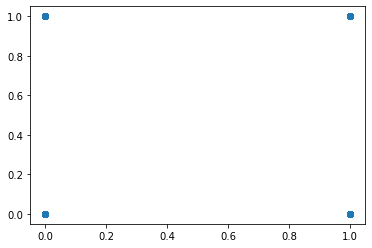

In [25]:
#checking how well the model does on the holdout-set 
gs.score(features_test,labels_test)
#plotting predicted body weights vs actual body weights of penguins 
labels_preds=gs.predict(features_test) 
plt.scatter(labels_test,labels_preds);

### Comparing kNN to Logistic

In [26]:
models = {
    'KNN': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression()
}

In [27]:
params={'KNN': {'selectkbest__k':[1,2,3,4,5,6],
                'kneighborsclassifier__n_neighbors' : [3,5,7,9,11,13,15,17,19],
                'kneighborsclassifier__weights' : ['uniform', 'distance'],
                'kneighborsclassifier__metric' : ['euclidian', 'manhattan']
                                 },
        'LogisticRegression': {'selectkbest__k':[1,2,3,4,5,6], 
                               'logisticregression__C' : [0.001, 0.01, 0.05, 0.1, 1., 100.], 
                               'logisticregression__penalty' : ['none', 'l1', 'l2', 'elasticnet'], 
                               'logisticregression__solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
                              }
       }

In [28]:
for name in models.keys():
    est = models[name]
    est_params = params[name]
    pipe = make_pipeline(StandardScaler(),SelectKBest(f_regression) ,est)
    gs = GridSearchCV(pipe, param_grid=est_params, verbose=0, n_jobs=-1, cv=5)
    gs.fit(features_train, labels_train)
    print(f"------{name}------")
    print(f"Best score: {gs.best_score_}")
    print(f"Best parameters are: {gs.best_params_}")

------KNN------
Best score: 0.756896551724138
Best parameters are: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 19, 'kneighborsclassifier__weights': 'distance', 'selectkbest__k': 5}
------LogisticRegression------
Best score: 0.7708245877061469
Best parameters are: {'logisticregression__C': 0.05, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear', 'selectkbest__k': 4}
